<a href="https://colab.research.google.com/github/Syswea/machine-learning-demo/blob/main/%E2%80%9Ctransformer_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [176]:
import torch
from torch import nn
import math
import numpy as np
import baostock as bs
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator, date2num
# pip install baostock mplfinance

In [177]:
SEED = 42
LOOKBACK = 30
FORECAST = 7
BATCH_SIZE = 64

NUM_LAYERS = 2
NUM_HEADS = 2
D_MODEL = 256
D_FF = 512
DROPOUT = 0.5
LR = 0.0001
EPOCHS = 2000
PATIENCE = 100

val_coef = 0.1
vaild_coef = 10
vol_coef = 1
rate_coef = 20
div_coef = 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.random.manual_seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

print(DEVICE)

cuda


In [178]:
print(torch.__version__)
print(torch.version.cuda)  # 如果输出 None，说明 PyTorch 没有编译 CUDA 支持
print(torch.cuda.is_available())

2.8.0+cu126
12.6
True


In [179]:
class Embedding(nn.Module):
    def __init__(self, num_features, d_model):
        super(Embedding, self).__init__()
        self.linear = nn.Linear(num_features, d_model)

    def forward(self, x):
        x = self.linear(x)
        return x

In [180]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)
        encoding = encoding.unsqueeze(0)

        # Register the encoding as a buffer so it is not a model parameter
        self.register_buffer('encoding', encoding)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :]

In [181]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.drop = nn.Dropout(dropout)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Q的形状: [batch_size, num_heads, seq_len, d_k]
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # 如果提供了mask，则将其应用于注意力分数
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # 应用softmax获取注意力权重
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.drop(attn_weights)

        # 应用注意力权重到值(V)
        output = torch.matmul(attn_weights, V)

        return output

    def split_heads(self, x):
        # 输入x的形状: [batch_size, seq_len, d_model]
        batch_size, seq_len = x.size(0), x.size(1)

        # 重塑为 [batch_size, seq_len, num_heads, d_k]
        x = x.view(batch_size, seq_len, self.num_heads, self.d_k)

        # 转置为 [batch_size, num_heads, seq_len, d_k]
        return x.transpose(1, 2)

    def combine_heads(self, x):
        # 输入x的形状: [batch_size, num_heads, seq_len, d_k]
        batch_size, _, seq_len = x.size(0), x.size(1), x.size(2)

        # 转置回 [batch_size, seq_len, num_heads, d_k]
        x = x.transpose(1, 2)

        # 重塑为 [batch_size, seq_len, d_model]
        return x.contiguous().view(batch_size, seq_len, self.d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # 线性变换
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)

        # 分割头
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)

        # 应用缩放点积注意力
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # 合并头
        output = self.combine_heads(attn_output)

        # 最终线性变换
        output = self.W_o(output)

        return output

In [182]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.activation = nn.GELU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

In [183]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.self_attn(x, x, x)
        x = self.drop(x)
        x = self.norm1(x + residual)

        residual = x
        x = self.feed_forward(x)
        x = self.drop(x)
        x = self.norm2(x + residual)

        return x

In [184]:
class Encoder(nn.Module):
    def __init__(self, num_feature,num_layers, d_model, num_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.embedding = Embedding(num_feature,d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.drop(x)

        for layer in self.layers:
            x = layer(x)

        return x

In [185]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads,dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads,dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm3 = nn.LayerNorm(d_model)

        self.drop = nn.Dropout(dropout)

    def forward(self, x, encode_ouput, mask):
        residual = x
        x = self.self_attn(x, x, x, mask)
        x = self.drop(x)
        x = self.norm1(x + residual)

        residual = x
        x = self.enc_dec_attn(x, encode_ouput, encode_ouput)
        x = self.drop(x)
        x = self.norm2(x + residual)

        residual = x
        x = self.feed_forward(x)
        x = self.drop(x)
        x = self.norm3(x + residual)

        return x

In [186]:
class Decoder(nn.Module):
    def __init__(self, num_feature,num_layers, d_model, num_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.embedding = Embedding(num_feature,d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(d_model, num_feature)

        self.drop = nn.Dropout(dropout)

    def forward(self, x, enc_output, mask):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.drop(x)

        for layer in self.layers:
            x = layer(x, enc_output, mask)

        x = self.fc(x)

        return x

In [187]:
def create_look_ahead_mask(size, device=None):
    mask = torch.triu(torch.ones(size, size), diagonal=1).type(torch.uint8)
    mask = mask == 0
    if device is not None:
        mask = mask.to(device)
    return mask

In [188]:
def validity_loss(x):
    """
    计算预测结果的合法性损失
    重点惩罚最低价高于最高价的情况
    """
    # 提取价格列 (open, high, low, close)
    # 假设预测结果的列顺序为: [open, high, low, close, volume, amount, turn, pctChg]
    high = x[:, :, 1]  # 最高价
    low = x[:, :, 2]   # 最低价
    open_price = x[:, :, 0]  # 开盘价
    close = x[:, :, 3]  # 收盘价

    # 1. 最低价不能高于最高价
    low_high_violation = torch.relu(low - high)  # 当low > high时，返回正差值

    # 2. 开盘价和收盘价应该在最低价和最高价之间
    open_bounds_violation = torch.relu(open_price - high) + torch.relu(low - open_price)
    close_bounds_violation = torch.relu(close - high) + torch.relu(low - close)

    # 3. 开盘价和收盘价不能为负
    price_non_negative = torch.relu(-open_price) + torch.relu(-close) + torch.relu(-high) + torch.relu(-low)

    # 组合所有损失，给最低价高于最高价的情况赋予更高的权重
    total_violation = (
        10.0 * low_high_violation +  # 最高权重给最低价高于最高价的情况
        5.0 * open_bounds_violation +
        5.0 * close_bounds_violation +
        12.0 * price_non_negative
    )

    return total_violation.mean()

In [189]:
def volatility_loss(x):
  batch_size, seq_len, num_features = x.shape
  price_features = x[:, :, :4]
  close = x[:, :, 3]  # 收盘价是第4个特征(索引3)
  x_returns = (close[:, 1:] - close[:, :-1]) / close[:, :-1]
  x_volatility = torch.std(x_returns, dim=1, keepdim=True)

  return x_volatility


In [190]:
def infer(encoder, decoder, inputs, infer_steps):
    """
    inputs: [1, seq_len, num_features]
    results: [infer_steps, num_features]
    """
    encoder.eval()
    decoder.eval()

    # 获取模型所在的设备
    device = next(encoder.parameters()).device

    # 确保输入数据在正确的设备上
    inputs = inputs.to(device)
    results = []

    with torch.no_grad():
        shift_outputs = inputs[:, -1:, :]

        encode = encoder(inputs)
        for _ in range(infer_steps):
            mask_size = shift_outputs.size(1)
            # 确保mask在正确的设备上
            mask = create_look_ahead_mask(mask_size, device)

            decode = decoder(shift_outputs, encode, mask)

            results.append(decode[:, -1, :])

            shift_outputs = torch.cat((shift_outputs, decode[:, -1, :].unsqueeze(1)), dim=1)

    return torch.cat(results, dim=0)

In [191]:
def prepare_data(data, lookback, forecast):
    X, y = [], []
    for i in range(len(data) - lookback - forecast + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+forecast])
    return np.array(X), np.array(y)

In [192]:
def fetch_data_loader():

    bs.login()
    rs = bs.query_history_k_data_plus("sh.600000",
        "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST",
        start_date='2018-01-01', end_date='2024-12-31',
        frequency="d", adjustflag="3")
    data_list = []
    while (rs.error_code == '0') & rs.next():
        data_list.append(rs.get_row_data())
    df = pd.DataFrame(data_list, columns=rs.fields)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    df = df.reset_index(drop=True)
    df = df[['open', 'high', 'low', 'close', 'volume', 'amount', 'turn', 'pctChg']]
    df = df.astype(float)

    print(df.head())

    bs.logout()

    # 对数变换
    from sklearn.model_selection import train_test_split
    from torch.utils.data import DataLoader, TensorDataset

    data = df.values

    # 对价格和成交量应用对数变换
    # 注意：pctChg已经是百分比变化，不需要变换
    price_columns = [0, 1, 2, 3]  # open, high, low, close
    volume_columns = [4, 5]  # volume, amount

    # 不应用对数变换（加上一个小常数避免log(0)）
    data[:, price_columns] = (data[:, price_columns])
    data[:, volume_columns] = (data[:, volume_columns])

    X, y = prepare_data(data, LOOKBACK, FORECAST)

    # 先划分训练集和验证集
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=False)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader

In [193]:
def diversity_loss(predicted):
    """
    鼓励预测序列具有多样性，防止所有预测值相同
    """
    pred_close = predicted[:, :, 3]

    # 计算价格变化的绝对值
    price_changes = torch.abs(pred_close[:, 1:] - pred_close[:, :-1])

    # 鼓励价格变化不为零
    return torch.exp(-price_changes.mean(dim=1)).mean()

In [194]:
def get_loss(predicted, target):

  pred_open = predicted[:, :, 0]
  pred_close = predicted[:, :, 3]
  tar_open = target[:, :, 0]
  tar_close = target[:, :, 3]

  # 计算预测序列的波动率

  pred_returns = (pred_close[:, 1:] - pred_close[:, :-1]) / pred_close[:, :-1]
  pred_volatility = torch.var(pred_returns, dim=1)

  target_close = target[:, :, 3]
  target_returns = (target_close[:, 1:] - target_close[:, :-1]) / target_close[:, :-1]
  target_volatility = torch.var(target_returns, dim=1)

  vol_loss = nn.functional.huber_loss(pred_volatility, target_volatility, reduction ='mean')

  # 非法
  vaild_loss = validity_loss(predicted)

  # 计算涨跌比例 - 鼓励50%的上涨天数
  daily_changes = pred_close - pred_open  # 每日价格变化
  up_days = (daily_changes > 0).float()   # 上涨的天数为1，下跌为0
  down_days = (daily_changes < 0).float() # 下跌的天数为1，上涨为0

  up_sum = up_days.sum(dim=1)
  down_sum = down_days.sum(dim=1)

  condition = (up_sum > 1) & (down_sum > 1)   # shape = (batch,)
  no_loss = torch.where(
      condition,
      torch.zeros_like(up_sum, dtype=torch.float),
      torch.full_like(up_sum, 1e7, dtype=torch.float)
  ).mean()  # 最后对 batch 求平均

  # 计算上涨天数比例
  pred_up_ratio = up_days.mean(dim=1)  # 每个序列的上涨比例

  # 鼓励上涨比例接近50%，但要避免除零错误
  target_ratio = torch.tensor(0.5, device=pred_up_ratio.device)
  rate_loss = torch.abs(pred_up_ratio - target_ratio).mean()

  # 值
  val_loss = nn.functional.huber_loss(pred_close[:, -1], tar_close[:, -1], reduction ='mean')

  # 鼓励变化
  div_loss = diversity_loss(predicted)

  return (val_coef * val_loss +
          vaild_coef * vaild_loss +
          vol_coef * vol_loss +
          rate_coef * rate_loss +
          div_coef * div_loss + no_loss), val_loss, rate_loss, no_loss

In [195]:
def train(encoder, decoder, train_loader, val_loader, lr, epochs, patience):
    # 使用全局 DEVICE 变量
    encoder.to(DEVICE)
    decoder.to(DEVICE)

    params = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(params, lr=lr)

    # 早停机制相关变量
    best_val_loss = float('inf')
    best_no_loss =  float('inf')
    patience_counter = 0
    best_model_state = {
        'encoder': None,
        'decoder': None,
        'epoch': -1,
        'val_loss': float('inf')
    }

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        train_loss = 0
        train_vaild_loss = 0
        train_rate_loss = 0
        train_no_loss = 0

        for train_x, train_y in train_loader:
            train_x, train_y = train_x.to(DEVICE), train_y.to(DEVICE)

            optimizer.zero_grad()

            enc_output = encoder(train_x)

            mask_size = train_y.size(1)
            # 使用全局 DEVICE 变量
            mask = create_look_ahead_mask(mask_size, DEVICE)

            decoder_input = torch.cat([train_x[:, -1:, :], train_y[:, :-1, :]], dim=1)

            dec_output = decoder(decoder_input, enc_output, mask)

            loss, vaild_loss, rate_loss, no_loss = get_loss(dec_output, train_y)
            loss.backward()

            # 添加梯度裁剪，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            train_vaild_loss += vaild_loss.item()
            train_rate_loss += rate_loss.item()
            train_no_loss += no_loss.item()

        train_avg_loss = train_loss / len(train_loader)
        train_avg_vaild_loss = train_vaild_loss / len(train_loader)
        train_avg_rate_loss = train_rate_loss / len(train_loader)
        train_avg_no_loss = train_no_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Total Loss: {train_avg_loss:.4f}, Vaild Loss: {train_avg_vaild_loss:.4f}, Rate Loss: {train_avg_rate_loss:.4f}, No loss :{train_avg_no_loss:.4f}")

        # Validation
        encoder.eval()
        decoder.eval()
        val_loss = 0
        val_vaild_loss = 0
        val_rate_loss = 0
        val_no_loss = 0
        with torch.no_grad():
            for val_x, val_y in val_loader:
                val_x, val_y = val_x.to(DEVICE), val_y.to(DEVICE)

                enc_output = encoder(val_x)

                mask_size = val_y.size(1)
                # 使用全局 DEVICE 变量
                mask = create_look_ahead_mask(mask_size, DEVICE)

                decoder_input = torch.cat([val_x[:, -1:, :], val_y[:, :-1, :]], dim=1)

                dec_output = decoder(decoder_input, enc_output, mask)

                # 组合损失
                loss, vaild_loss, rate_loss, no_loss = get_loss(dec_output, val_y)

                val_loss += loss.item()
                val_vaild_loss += vaild_loss.item()
                val_rate_loss += rate_loss.item()
                val_no_loss  += no_loss.item()
                
        val_avg_loss = val_loss / len(val_loader)
        val_avg_vaild_loss = val_vaild_loss / len(val_loader)
        val_avg_rate_loss = val_rate_loss / len(val_loader)
        val_avg_no_loss = val_no_loss / len(val_loader)
        print(f"Val - Total Loss: {val_avg_loss:.4f}, Vaild Loss: {val_avg_vaild_loss:.4f}, Rate Loss: {val_avg_rate_loss:.4f}, No loss :{val_avg_no_loss:.4f}")

        # 早停机制检查
        if val_avg_loss < best_val_loss and (val_avg_no_loss < best_no_loss or train_avg_no_loss < best_no_loss):
            best_val_loss = val_avg_loss
            best_no_loss = min(train_avg_no_loss, val_avg_no_loss)
            patience_counter = 0
            # 保存最佳模型状态
            best_model_state = {
                'encoder': encoder.state_dict().copy(),
                'decoder': decoder.state_dict().copy(),
                'epoch': epoch,
                'val_loss': val_avg_loss
            }
            print(f"Validation loss improved to {val_avg_loss:.4f}, saving model...")
        else:
            patience_counter += (val_avg_no_loss < best_no_loss)
            print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")

        # 检查是否应该早停
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.4f}")
            # 恢复最佳模型
            encoder.load_state_dict(best_model_state['encoder'])
            decoder.load_state_dict(best_model_state['decoder'])
            break

    # 如果没有早停，确保最后保存的是最佳模型
    if patience_counter < patience:
        encoder.load_state_dict(best_model_state['encoder'])
        decoder.load_state_dict(best_model_state['decoder'])
        print(f"Training completed. Best validation loss: {best_val_loss:.4f} at epoch {best_model_state['epoch']+1}")

In [196]:
# 在训练前添加设备检查
print(f"Using device: {DEVICE}")

# 获取数据
train_loader, val_loader = fetch_data_loader()

# 获取特征数量
num_features = train_loader.dataset[0][0].shape[-1]

# 初始化模型
encoder = Encoder(num_features, NUM_LAYERS, D_MODEL, NUM_HEADS, D_FF, DROPOUT)
decoder = Decoder(num_features, NUM_LAYERS, D_MODEL, NUM_HEADS, D_FF, DROPOUT)

# 训练模型
train(encoder, decoder, train_loader, val_loader, lr=LR, epochs=EPOCHS, patience=PATIENCE)

# 示例推理
# 获取一个样本进行推理
sample_input, sample_output = val_loader.dataset[3]
sample_input = sample_input.unsqueeze(0)  # 添加批次维度

# 确保模型在正确的设备上
encoder.to(DEVICE)
decoder.to(DEVICE)
sample_input = sample_input.to(DEVICE)

predictions = infer(encoder, decoder, sample_input, FORECAST)

predictions = predictions.cpu().numpy()
sample_output = sample_output.numpy()

# 反对数变换
# 对价格和成交量应用对数变换
# 注意：pctChg已经是百分比变化，不需要变换
price_columns = [0, 1, 2, 3]  # open, high, low, close
volume_columns = [4, 5]  # volume, amount

# 应用对数变换（加上一个小常数避免log(0)）
predictions[:, price_columns] = (predictions[:, price_columns])
predictions[:, volume_columns] = (predictions[:, volume_columns])
sample_output[:, price_columns] = (sample_output[:, price_columns])
sample_output[:, volume_columns] = (sample_output[:, volume_columns])


Using device: cuda
login success!
    open   high    low  close      volume       amount      turn    pctChg
0  12.61  12.77  12.60  12.72  31323053.0  398614966.0  0.111455  1.032566
1  12.73  12.80  12.66  12.66  37839101.0  480954809.0  0.134641 -0.471701
2  12.70  12.73  12.62  12.66  27883804.0  353205838.0  0.099217  0.000000
3  12.67  12.71  12.62  12.69  31026744.0  393058250.0  0.110401  0.236965
4  12.69  12.71  12.63  12.68  31389887.0  397842209.0  0.111693 -0.078797
logout success!
Epoch [1/2000], Total Loss: 8542058.3631, Vaild Loss: 10.0175, Rate Loss: 0.4241, No loss :8513095.2381
Val - Total Loss: 10000199.6667, Vaild Loss: 8.5174, Rate Loss: 0.5000, No loss :10000000.0000
Validation loss improved to 10000199.6667, saving model...
Epoch [2/2000], Total Loss: 10083222.3810, Vaild Loss: 9.9052, Rate Loss: 0.4866, No loss :9970238.0952
Val - Total Loss: 10000280.3333, Vaild Loss: 9.2634, Rate Loss: 0.5000, No loss :10000000.0000
Validation loss did not improve. Patience: 

In [197]:
# 'open', 'high', 'low', 'close', 'volume', 'amount', 'turn', 'pctChg'
print(predictions.shape)  # 应该是 (FORECAST, num_features) (7, 8)
print("Predictions:", predictions)

(7, 8)
Predictions: [[ 7.1315794  30.161545    2.5800874  23.137632   -0.52352667  0.14171562
  -0.30000144 -0.30221367]
 [ 4.9176397  11.759271    1.7331735   5.9568925  -0.08559322  0.40665486
  -0.20792662 -0.20507394]
 [ 4.911577   11.703045    1.72865     5.917325   -0.08753055  0.3940865
  -0.22307605 -0.21832494]
 [ 4.914396   11.724677    1.7271953   5.9415207  -0.09012434  0.38552663
  -0.23451051 -0.22675428]
 [ 4.919827   11.767847    1.72687     5.9820275  -0.09273257  0.3791132
  -0.243489   -0.2326883 ]
 [ 4.926527   11.819717    1.7272326   6.0288696  -0.09529347  0.37396652
  -0.25074068 -0.23720059]
 [ 4.9341617  11.877377    1.7281348   6.0802374  -0.09782842  0.3696411
  -0.2567513  -0.24083495]]


In [198]:
def plot_kline(predictions, start_date=None):
    """
    绘制7天K线图
    """
    # 验证输入
    assert predictions.shape == (7, 8), f"Expected (7,8), got {predictions.shape}"

    ohlc = predictions[:, :4]  # open, high, low, close
    volume = predictions[:, 4]  # volume

    # 处理日期
    if start_date is None:
        start_date = datetime.now()
    else:
        start_date = datetime.strptime(start_date, "%Y-%m-%d")

    # 只保留日期，去除时间部分
    start_date = start_date.replace(hour=0, minute=0, second=0, microsecond=0)
    dates = [start_date + timedelta(days=i) for i in range(7)]

    EPS = 1e-5  # 容差，防止浮点误差误报

    for i in range(7):
        o, h, l, c = ohlc[i]

        if h < l - EPS:
            print(f"警告: high < low [H={h:.4f}, L={l:.4f}]")
        elif o < l - EPS or o > h + EPS:
            print(f"警告: open 超出 [low, high] 范围 [O={o:.4f}, L={l:.4f}, H={h:.4f}]")
        elif c < l - EPS or c > h + EPS:
            print(f"警告: close 超出 [low, high] 范围 [C={c:.4f}, L={l:.4f}, H={h:.4f}]")

    # 准备 OHLC 数据
    ohlc_data = [
        [date2num(date), o, h, l, c]
        for date, (o, h, l, c) in zip(dates, ohlc)
    ]

    # 创建子图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})

    # 绘制 K 线
    candlestick_ohlc(ax1, ohlc_data, width=0.6, colorup='red', colordown='green')  # A股习惯：红涨绿跌
    ax1.set_title('7-Day Stock Price Prediction', fontsize=14)
    ax1.set_ylabel('price')
    ax1.xaxis.set_major_formatter(DateFormatter('%m-%d'))  # 显示月-日
    ax1.xaxis.set_major_locator(DayLocator())
    ax1.grid(True, axis='y', alpha=0.3)

    # 旋转标签
    for label in ax1.xaxis.get_majorticklabels():
        label.set_rotation(45)

    # 绘制成交量
    ax2.bar([date2num(date) for date in dates], volume, width=0.6, color='gray', alpha=0.7)
    ax2.set_ylabel('Volume')
    ax2.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ax2.xaxis.set_major_locator(DayLocator())
    ax2.grid(True, axis='y', alpha=0.3)

    for label in ax2.xaxis.get_majorticklabels():
        label.set_rotation(45)

    plt.tight_layout()
    plt.show()

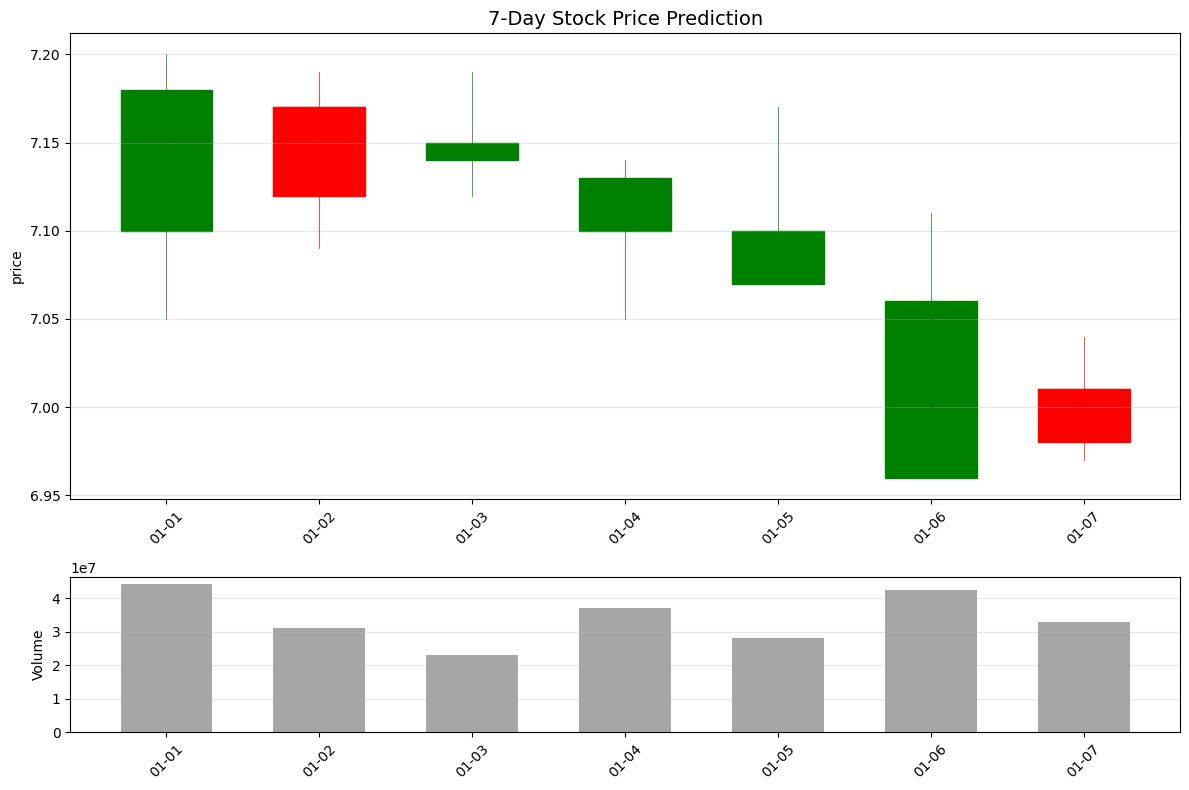

[[ 7.1799998e+00  7.1999998e+00  7.0500002e+00  7.0999999e+00
   4.4245536e+07  3.1500774e+08  1.5070000e-01 -1.7981000e+00]
 [ 7.1199999e+00  7.1900001e+00  7.0900002e+00  7.1700001e+00
   3.1218656e+07  2.2258286e+08  1.0640000e-01  9.8589998e-01]
 [ 7.1500001e+00  7.1900001e+00  7.1199999e+00  7.1399999e+00
   2.2953984e+07  1.6392326e+08  7.8199998e-02 -4.1839999e-01]
 [ 7.1300001e+00  7.1399999e+00  7.0500002e+00  7.0999999e+00
   3.7202484e+07  2.6359898e+08  1.2670000e-01 -5.6019998e-01]
 [ 7.0999999e+00  7.1700001e+00  7.0700002e+00  7.0700002e+00
   2.8150556e+07  2.0037202e+08  9.5899999e-02 -4.2250001e-01]
 [ 7.0599999e+00  7.1100001e+00  6.9600000e+00  6.9600000e+00
   4.2517680e+07  2.9841952e+08  1.4489999e-01 -1.5559000e+00]
 [ 6.9800000e+00  7.0400000e+00  6.9699998e+00  7.0100002e+00
   3.2939984e+07  2.3049138e+08  1.1220000e-01  7.1840000e-01]]


In [199]:
plot_kline(sample_output, start_date="2024-01-01")
print(sample_output)

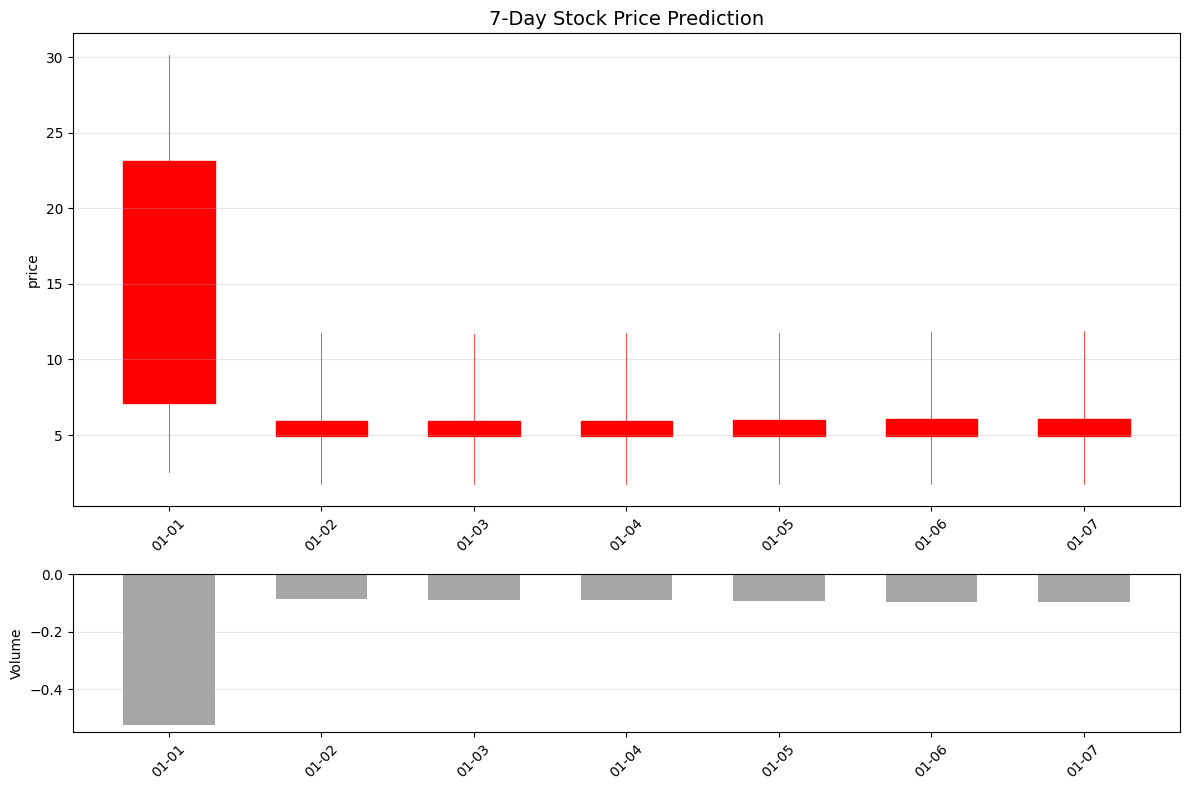

[[ 7.1315794  30.161545    2.5800874  23.137632   -0.52352667  0.14171562
  -0.30000144 -0.30221367]
 [ 4.9176397  11.759271    1.7331735   5.9568925  -0.08559322  0.40665486
  -0.20792662 -0.20507394]
 [ 4.911577   11.703045    1.72865     5.917325   -0.08753055  0.3940865
  -0.22307605 -0.21832494]
 [ 4.914396   11.724677    1.7271953   5.9415207  -0.09012434  0.38552663
  -0.23451051 -0.22675428]
 [ 4.919827   11.767847    1.72687     5.9820275  -0.09273257  0.3791132
  -0.243489   -0.2326883 ]
 [ 4.926527   11.819717    1.7272326   6.0288696  -0.09529347  0.37396652
  -0.25074068 -0.23720059]
 [ 4.9341617  11.877377    1.7281348   6.0802374  -0.09782842  0.3696411
  -0.2567513  -0.24083495]]


In [200]:
plot_kline(predictions, start_date="2024-01-01")
print(predictions)